# Trabajo integrador - Parte 2

# Aprendizaje Supervisado

**Nombre**: Víctor David Silva

## Problema de regresión

Para la creación de los datasets y la manipulación de los mismos vamos a trabajar directamente con dos módulos includios en la carpeta utils.

En esta podemos encontrar:
 - generate_data: Esta función wrappea el método de _make_regression_ de scikit learn para devolver un dataframe con un problema de regresión basado en sus parámetros.
 - generate_outliers: Esta función genera outliers livianos y pesados en función de los parámetros que le demos de entrada.

In [114]:
#from utils.data_generation import generate_dataset
import numpy as np
import pandas as pd

from sklearn.datasets import make_regression
from typing import Optional, Union

def generate_dataset(n_samples: int = 1000,
                     n_features: int = 10,
                     n_informative: int = 5,
                     n_targets: int = 1,
                     noise: float = 10.0,
                     bias: float = 0.0,
                     random_state: Optional[int] = None,
                     effective_rank: Optional[int] = None,
                     output: str = 'dataframe') -> Union[pd.DataFrame,np.ndarray]:
    """
    Generate a regression dataset.
    The input parameters are the same as sklearn.datasets.make_regression
    """

    X, y, _ = make_regression(n_samples=n_samples,
                           n_features=n_features,
                           n_informative=n_informative,
                           n_targets=n_targets,
                           noise=noise,
                           effective_rank= effective_rank,
                           bias=bias,
                           coef=True,
                           shuffle = False,
                           random_state=random_state)
    
    if output == 'dataframe':
        df = pd.DataFrame(X, columns=[f'x{i}' for i in range(n_features)])
        df['target'] = y
        return df
    elif output == 'array':
        return X, y
    else:
        raise ValueError('output must be either "dataframe" or "array"')

In [115]:
#from utils.data_manipulation import generate_outliers
#import numpy as np
#import pandas as pd

def generate_outliers(
    df: pd.DataFrame,
    columns: list = None,
    percentage: float = 0.01,
    extreme_outliers: bool = False,
    only_tails: bool = False,
    two_tailed: bool = True,
):
    """
    Generate outliers in the distribution of a DataFrame.

    Parameters:
    df (DataFrame): Input DataFrame containing features and one output.
    percentage (float): Percentage of total data points that should be replaced with outliers.
    extreme_outliers (bool): If True, it generates points with a big leverage.
    only_tails (bool): If True, generates outliers only in the tails (close to the min and max of the feature values).
    two_tailed (bool): If True, generates outliers from both parts of the feature (both in the min and the max).

    Returns:
    DataFrame: DataFrame with the newly generated outliers.
    """

    outlier_df = df.copy()

    if columns is None:
        columns = df.drop("target", axis=1).columns

    for column in columns:
        # Set the amount of leverage for the outliers
        leverage = 3 if extreme_outliers else 1.5

        # Calculate the IQR of the column
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1

        # Set the lower and upper bounds for outliers
        lower_bound = Q1 - (IQR * leverage)
        upper_bound = Q3 + (IQR * leverage)

        # Get the total number of outliers to be introduced
        num_outliers = int(df.shape[0] * percentage)

        # Depending on the settings, generate outliers at different places in the distribution
        if only_tails:
            if two_tailed:
                # Generate outliers in the lower and upper tails
                lower_indices = np.random.choice(
                    df[df[column] < (Q1 - (IQR))].index,
                    size=num_outliers // 2,
                    replace=True,
                )
                upper_indices = np.random.choice(
                    df[df[column] > (Q3 + (IQR))].index,
                    size=num_outliers // 2,
                    replace=True,
                )
                outlier_df.loc[lower_indices, column] = np.random.uniform(
                    lower_bound, Q1, size=num_outliers // 2
                )
                outlier_df.loc[upper_indices, column] = np.random.uniform(
                    Q3, upper_bound, size=num_outliers // 2
                )
            else:
                # Generate outliers in the upper tail
                upper_indices = np.random.choice(
                    df[df[column] > upper_bound].index, size=num_outliers, replace=True
                )
                outlier_df.loc[upper_indices, column] = np.random.uniform(
                    upper_bound, df[column].max(), size=num_outliers
                )
        else:
            # Generate outliers throughout the distribution
            indices = np.random.choice(df.index, size=num_outliers, replace=True)
            outlier_df.loc[indices, column] = np.random.uniform(
                df[column].min(), df[column].max(), size=num_outliers
            )

    return outlier_df


### Ejemplo de uso

In [116]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [117]:
## Vamos a crear un dataset primero.

data = generate_dataset(
    n_samples=1000,
    n_features=5,
    n_informative=2,
    n_targets=1,
    noise=0,
    output='dataframe'
)

## esto nos genera un dataset que contiene 5 features, 2 de los cuales son informativos, y 1 target.

data.head()

,x0,x1,x2,x3,x4,target
0,0.522244,-0.816404,0.191507,0.068371,-1.055387,-50.131817
1,1.058485,0.203303,-0.284683,-0.438110,0.139777,58.844665
2,0.407925,-0.124976,-2.832520,0.016891,-1.441482,5.119149
3,-0.209453,-1.404564,-1.416498,1.235122,-0.320092,-129.464973
4,-0.396662,0.482524,-0.370591,2.103806,-0.273020,26.197222


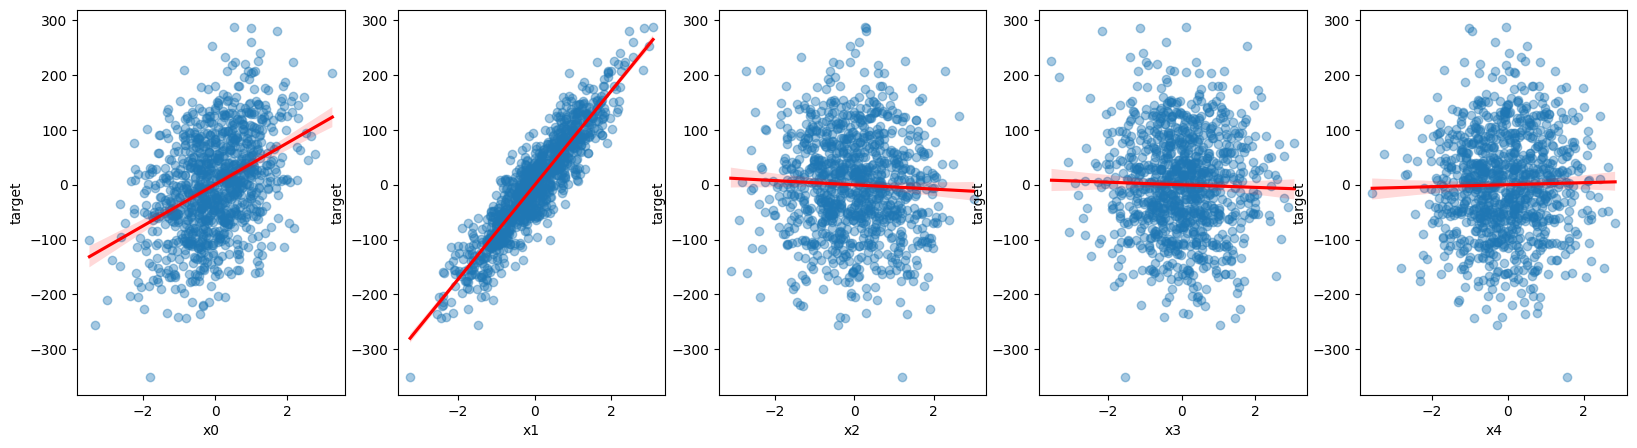

In [118]:
## vamos a visualizar estas variables
## creamos una figura de matplotlib que contenga 5 subplots, uno por cada feature:

fig, axes = plt.subplots(1, 5, figsize=(20, 5))

## Creamos un loop para iterar sobre cada feature y graficar la regresión lineal entre cada feature y el target:

for i, feature in enumerate(data.columns[:-1]):
    sns.regplot(x=feature,
                y='target',
                data=data,
                ax=axes[i],
                scatter_kws={'alpha': 0.4},
                line_kws={'color': 'red'},
                ci=95)
    


Ahora agregamos _outliers_ a un nuevo dataset

In [119]:
data = generate_dataset(
    n_samples=1000,
    n_features=1,
    n_informative=1,
    n_targets=1,
    noise=0,
    output='dataframe'
)


In [120]:
do1 = generate_outliers(
    df=data,
    columns=['x0'],
    percentage=0.01,
    extreme_outliers=False,
    only_tails=False,
)
do2 = generate_outliers(
    df=data,
    columns=['x0'],
    percentage=0.01,
    extreme_outliers=False,
    only_tails=True,
    two_tailed=True,
)
do3 = generate_outliers(
    df=data,
    columns=['x0'],
    percentage=0.01,
    extreme_outliers=False,
    only_tails=True,
    two_tailed=False,
)

Text(0.5, 1.0, 'Outliers (one-tailed)')

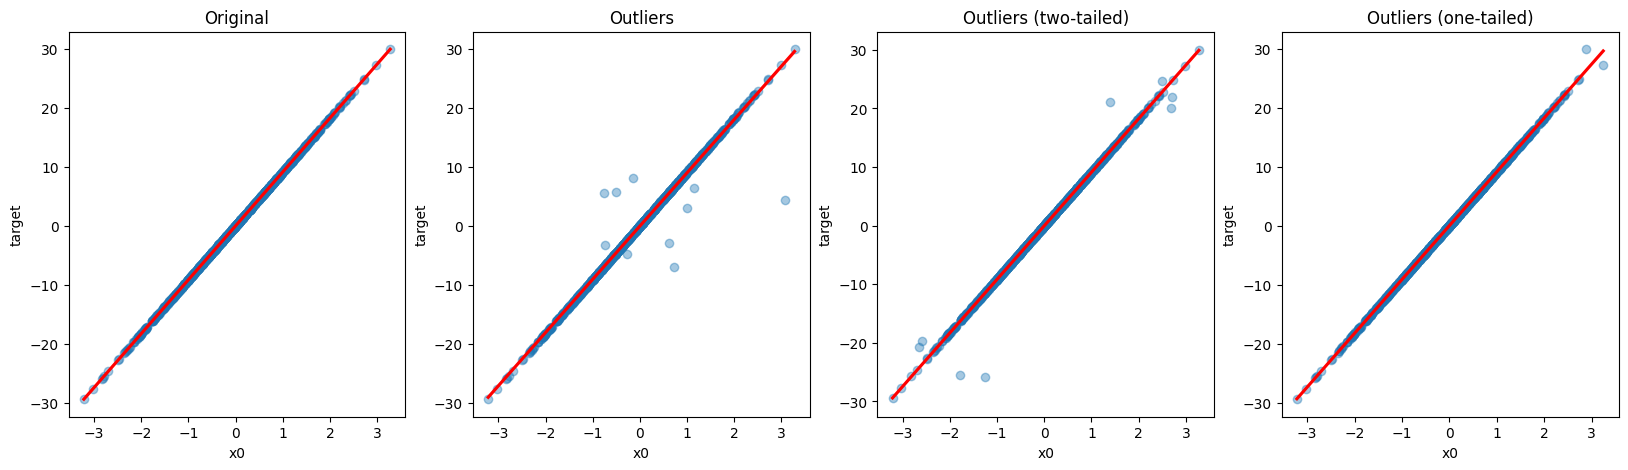

In [121]:
## vamos a visualizar estas los distintos datasets

fig, axes = plt.subplots(1, 4, figsize=(20, 5))

sns.regplot(x='x0',
            y='target',
            data=data,
            ax=axes[0],
            scatter_kws={'alpha': 0.4},
            line_kws={'color': 'red'},
            ci=95)
axes[0].set_title('Original')

sns.regplot(x='x0',
            y='target',
            data=do1,
            ax=axes[1],
            scatter_kws={'alpha': 0.4},
            line_kws={'color': 'red'},
            ci=95)
axes[1].set_title('Outliers')

sns.regplot(x='x0',
            y='target',
            data=do2,
            ax=axes[2],
            scatter_kws={'alpha': 0.4},
            line_kws={'color': 'red'},
            ci=95)
axes[2].set_title('Outliers (two-tailed)')

sns.regplot(x='x0',
            y='target',
            data=do3,
            ax=axes[3],
            scatter_kws={'alpha': 0.4},
            line_kws={'color': 'red'},
            ci=95)
axes[3].set_title('Outliers (one-tailed)')


Text(0.5, 1.0, 'Outliers')

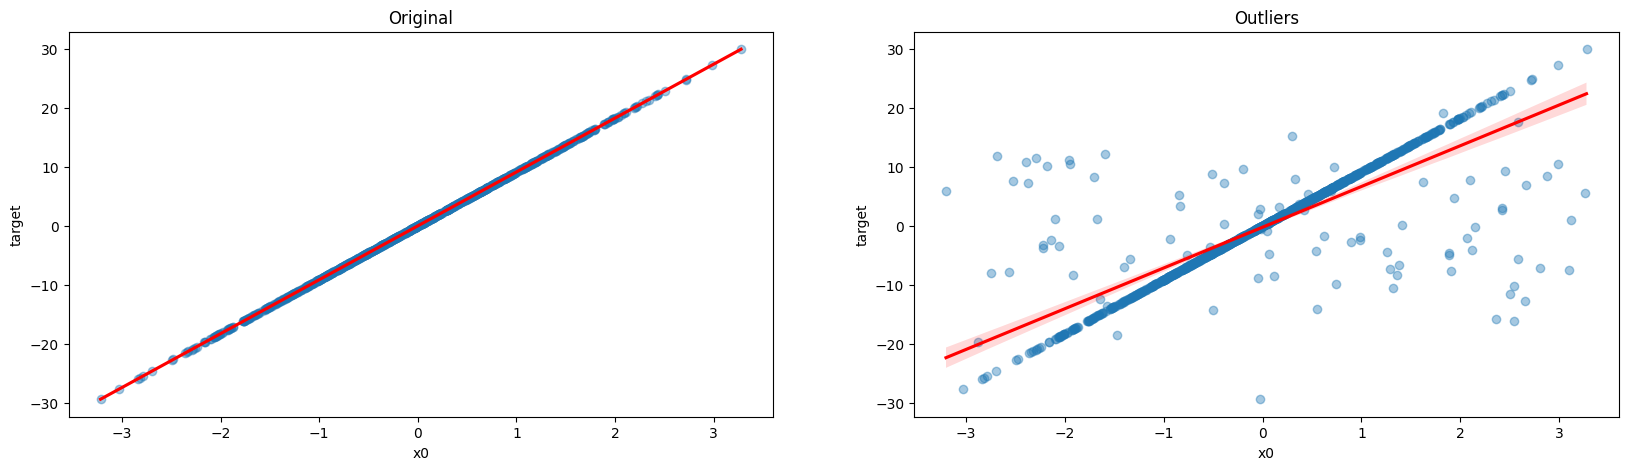

In [122]:
## y si lo queremos con mucho mas outliers?

doe = generate_outliers(
    df=data,
    columns=['x0'],
    percentage=0.1,
    extreme_outliers=True)

## vamos a visualizar este caso

fig, axes = plt.subplots(1, 2, figsize=(20, 5))

sns.regplot(x='x0',
            y='target',
            data=data,
            ax=axes[0],
            scatter_kws={'alpha': 0.4},
            line_kws={'color': 'red'},
            ci=95)
axes[0].set_title('Original')

sns.regplot(x='x0',
            y='target',
            data=doe,
            ax=axes[1],
            scatter_kws={'alpha': 0.4},
            line_kws={'color': 'red'},
            ci=95)
axes[1].set_title('Outliers')


## Ejercicio 4

Utilizando la funcion `generate_data` generar un problema de regresión multivariada en el cual cuente con N variables informativas y M variables no informativas.

Ejemplo:
```python
data = generate_dataset(n_samples=1000,
                    n_features=10,
                    n_informative=5,
                    n_targets=1,
                    noise=20.0,
                    random_state=42,
                    output='dataframe')

```

Dado un valor de _noise_ fijo, sin fijar _random_state_ (para poder asegurarnos
que los datos que generamos son distintos) realizaremos 100 simulaciones de este dataset.

En la simulación deberemos generar el dataset, hacer una división de train-test, ajustar
un modelo de regresión lineal multivariada y validar el mismo.

En cada iteración de esta simulación debemos guardar:

- Los coeficientes de la regresión.
- El RMSE de train y test.
- El MAE de train y test. 


> Qué pasa con los coeficientes de las variables no informativas? La regresión se ve afectada por estas variables?
> ***HINT:*** Utilice las distribuciones de los coeficientes para analizar y test de hipótesis para sacar conclusiones.

In [123]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [124]:
def rmse(target, prediction):
    n = target.size
    return np.sqrt(np.sum((target - prediction)**2)/n)

def mae(target, prediction):
    n = target.size
    return np.sum(np.abs(target - prediction),axis=0)/n

In [125]:
## Parámetros de la simulación
n_exp = 100
n_samples = 1000
n_features = 10
n_informative = 2
n_targets = 1

#noise = np.linspace(0, 100, 100)
#bias = np.linspace(0, 100, 20)


In [126]:
def simulation (n_exp, n_samples, n_features, n_informative, n_targets, n, b):
    rmse_train_list = []
    rmse_test_list = []
    mae_train_list = []
    mae_test_list = []
    coef_list = []
    for _ in tqdm(range(n_exp)):
        data = generate_dataset(
            n_samples=n_samples,
            n_features=n_features,
            n_informative=n_informative,
            n_targets=n_targets,
            noise=n,
            bias=b,
            output='dataframe'
        )
        #x,y,coef = make_regression(n_samples=500, n_features=1, n_informative=1, bias=3, noise=5,coef=True)   
                
        X=data.drop('target', axis=1)
        y = data['target']

        X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)
        
        linear_regression = LinearRegression()
        linear_regression.fit(X_train, y_train)
        lr_y_train_predict = linear_regression.predict(X_train)
        lr_y_test_predict = linear_regression.predict(X_test)
    
        lr_rmse_train = rmse(y_train, lr_y_train_predict)
        lr_rmse_test = rmse(y_test, lr_y_test_predict)
        lr_mae_train = mae(y_train, lr_y_train_predict)
        lr_mae_test = mae(y_test, lr_y_test_predict)

        coef = linear_regression.coef_
        
        rmse_train_list.append(lr_rmse_train)
        rmse_test_list.append(lr_rmse_test)
        mae_train_list.append(lr_mae_train)
        mae_test_list.append(lr_mae_test)
        coef_list.append(coef)
    return data, rmse_train_list, rmse_test_list, mae_train_list, mae_test_list, coef_list, linear_regression
    

n_1 = 10
b_1 = 20
data_1, rmse_train_list_1, rmse_test_list_1, mae_train_list_1, mae_test_list_1, coef_list_1, linear_regression_1 = simulation (n_exp, n_samples, n_features, n_informative, n_targets, n_1, b_1)     

n_2 = 50
b_2 = 20
data_2, rmse_train_list_2, rmse_test_list_2, mae_train_list_2, mae_test_list_2, coef_list_2, linear_regression_2 = simulation (n_exp, n_samples, n_features, n_informative, n_targets, n_2, b_2)     

n_3 = 100
b_3 = 20
data_3, rmse_train_list_3, rmse_test_list_3, mae_train_list_3, mae_test_list_3, coef_list_3, linear_regression_3 = simulation (n_exp, n_samples, n_features, n_informative, n_targets, n_3, b_3)     




100%|██████████| 100/100 [00:01<00:00, 98.22it/s]


Se observan las distribuciones para comparar las de las variables informativas con las no informativas.

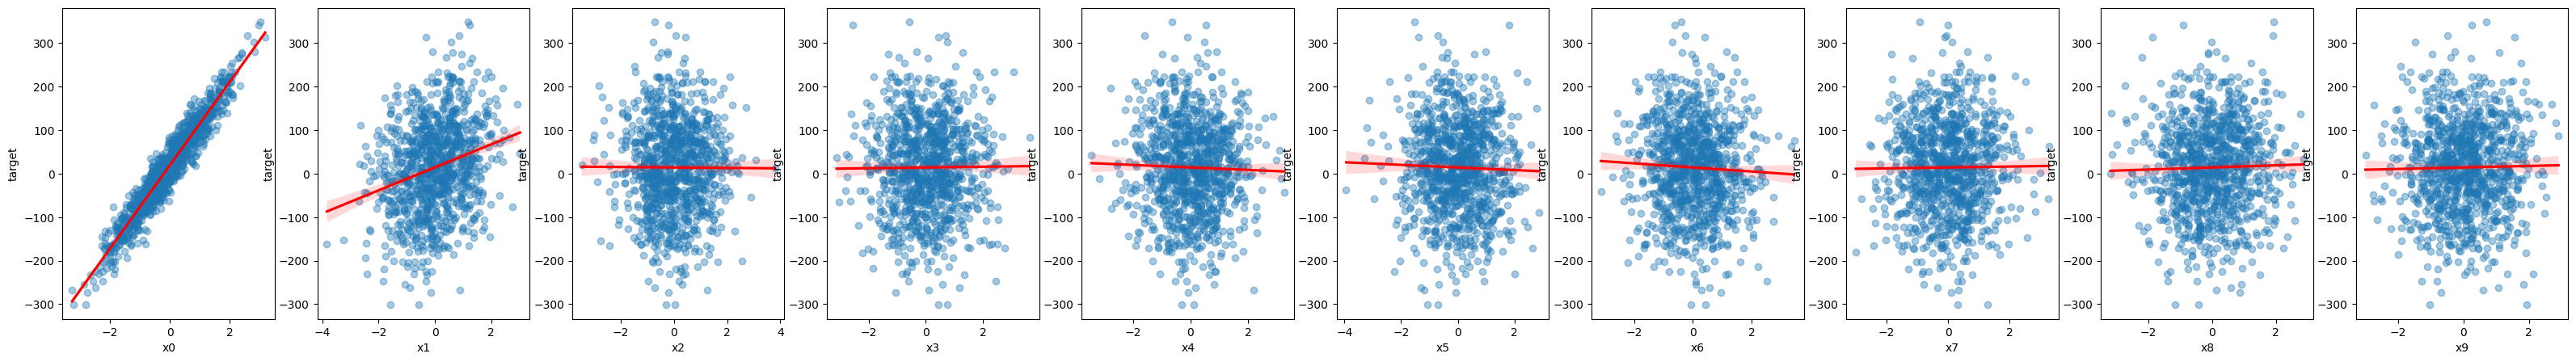

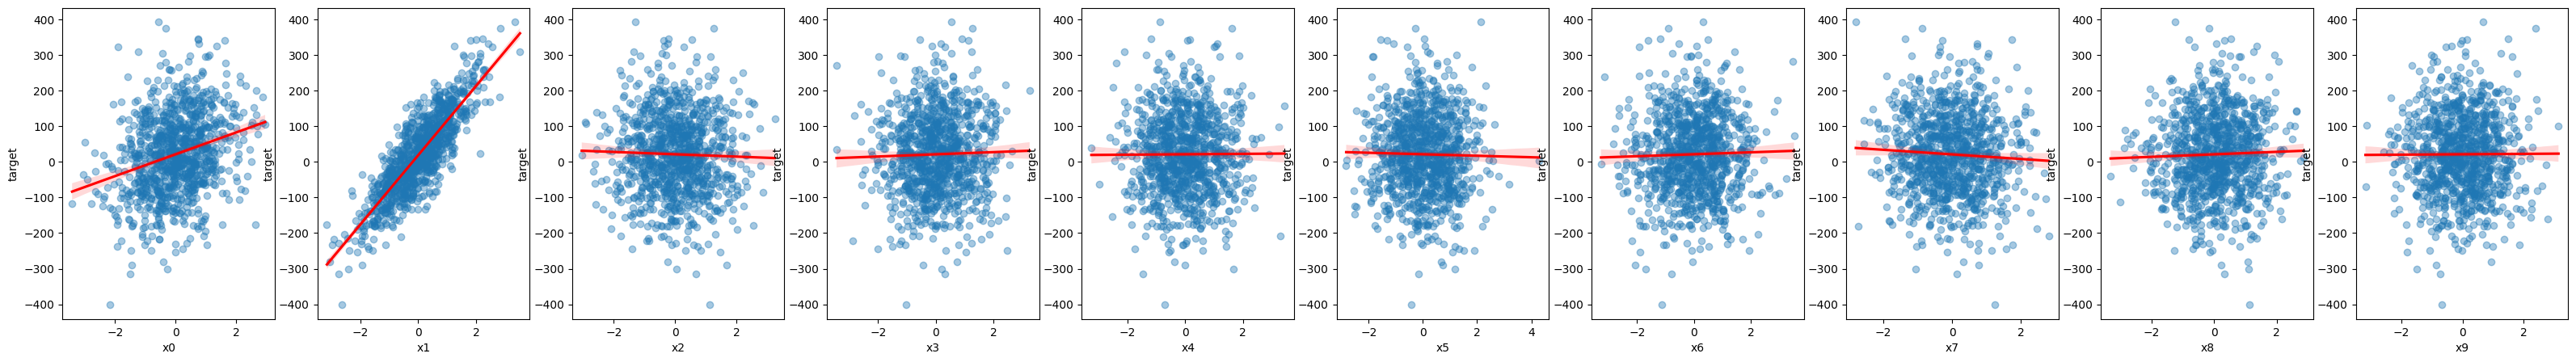

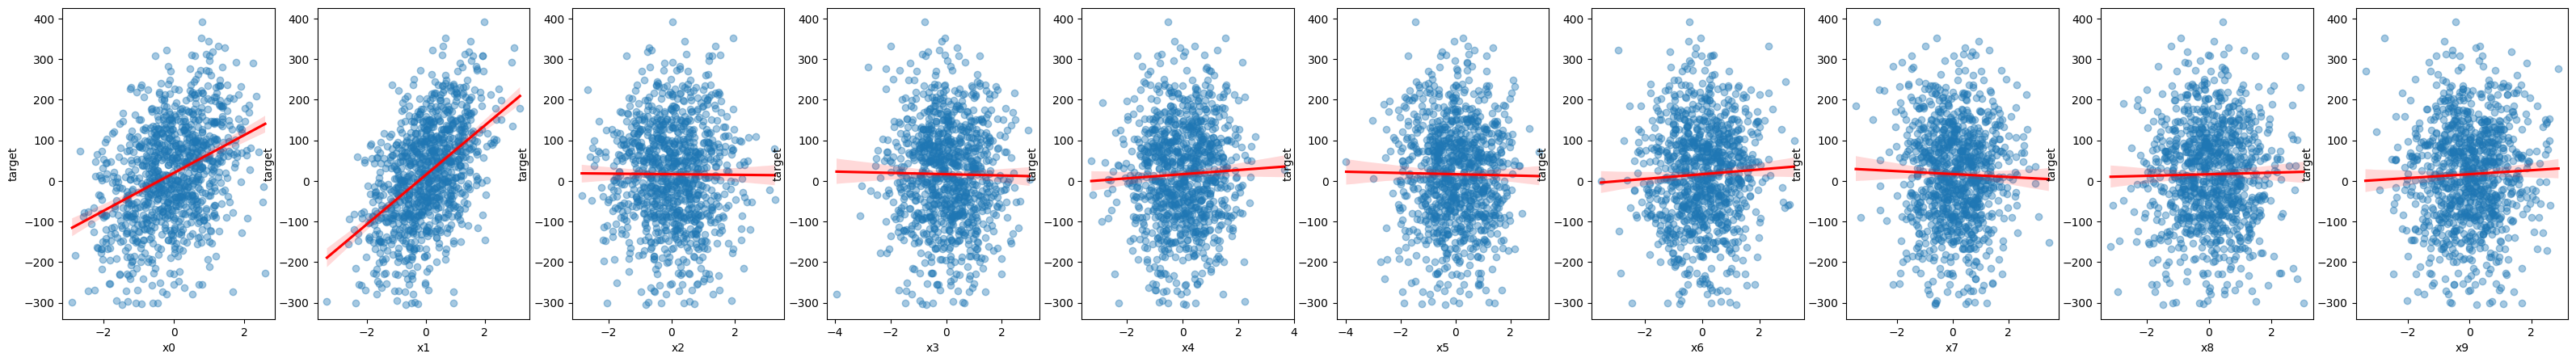

In [127]:
fig, axes = plt.subplots(1, 10, figsize=(40, 5))

for i, feature in enumerate(data_1.columns[:-1]):
    sns.regplot(x=feature,
                y='target',
                data=data_1,
                ax=axes[i],
                scatter_kws={'alpha': 0.4},
                line_kws={'color': 'red'},
                ci=95)

fig, axes = plt.subplots(1, 10, figsize=(40, 5))

for i, feature in enumerate(data_2.columns[:-1]):
    sns.regplot(x=feature,
                y='target',
                data=data_2,
                ax=axes[i],
                scatter_kws={'alpha': 0.4},
                line_kws={'color': 'red'},
                ci=95)
    
fig, axes = plt.subplots(1, 10, figsize=(40, 5))

for i, feature in enumerate(data_3.columns[:-1]):
    sns.regplot(x=feature,
                y='target',
                data=data_3,
                ax=axes[i],
                scatter_kws={'alpha': 0.4},
                line_kws={'color': 'red'},
                ci=95)

Se observa que la regresión no se afectada por las  variables no informativas.  

Se comparan los RMSE y MAE tanto de test, como de train con diferentes ruido.

In [128]:
pd.DataFrame(list(zip(rmse_train_list_1, mae_train_list_1, rmse_test_list_1, mae_test_list_1, rmse_train_list_2, mae_train_list_2, rmse_test_list_2, mae_test_list_2, rmse_train_list_3, mae_train_list_3,  rmse_test_list_3, mae_test_list_3)), columns=['RMSE Train 1','MAE Train 1', 'RMSE Test 1','MAE Test 1','RMSE Train 2','MAE Train 2', 'RMSE Test 2','MAE Test 2','RMSE Train 3','MAE Train 3', 'RMSE Test 3','MAE Test 3'])

,RMSE Train 1,MAE Train 1,RMSE Test 1,MAE Test 1,RMSE Train 2,MAE Train 2,RMSE Test 2,MAE Test 2,RMSE Train 3,MAE Train 3,RMSE Test 3,MAE Test 3
0,10.080695,8.033471,9.523206,7.416665,49.979083,40.060128,47.299135,37.611384,100.835433,81.229818,99.244927,78.922315
1,9.964197,8.002665,10.360123,8.171330,49.608684,39.947321,49.797941,40.884147,100.371848,79.526521,101.445685,82.180862
2,9.767881,7.831315,9.421332,7.565484,50.793118,40.467077,47.284105,36.552834,97.271954,77.568982,105.062651,83.455835
3,9.607071,7.644294,10.139446,8.193068,49.712909,39.432518,48.686510,38.487823,102.229879,81.612240,105.654803,84.789105
4,9.979416,8.044982,10.189626,8.262549,49.138475,39.283947,51.678432,40.968529,100.694209,80.274067,98.344287,77.310113
...,...,...,...,...,...,...,...,...,...,...,...,...
95,10.003567,7.838776,9.964534,7.764729,48.981154,39.940310,49.483181,39.062461,103.259752,81.138373,94.413177,77.262884
96,10.620647,8.407243,10.114984,7.999971,48.883890,39.074987,48.164151,38.294809,100.567749,80.468210,96.075819,76.662403
97,10.135437,8.076311,9.846020,7.748459,49.777848,39.458891,51.291070,40.219066,98.778797,79.276942,103.688370,84.659091
98,10.275719,8.210829,10.548677,8.471504,46.203968,36.856535,50.780329,39.575948,106.873854,85.076168,103.948891,85.577450


In [129]:
pd.DataFrame(list(zip(np.round(coef_list_1,2), np.round(coef_list_2,2), np.round(coef_list_3,2))), columns=['Coef. list 1','Coef. list 2', 'Coef. list 3'])

,Coef. list 1,Coef. list 2,Coef. list 3
0,"[93.99, 31.22, -0.05, -0.01, 0.07, 0.24, -0.08...","[82.63, 59.27, 0.02, -1.34, 0.82, -1.13, -2.75...","[62.27, 63.82, 2.26, 0.42, -0.06, -2.01, -0.64..."
1,"[61.15, 87.56, -0.01, -0.6, 0.13, 0.45, 0.02, ...","[45.98, 4.7, -0.13, -2.49, 0.17, -0.26, -0.5, ...","[6.69, 52.03, -7.27, -2.69, 3.04, 0.86, -4.94,..."
2,"[95.56, 56.75, 0.64, 0.23, -0.53, 0.08, -0.54,...","[30.05, 75.45, 3.13, 1.24, 2.1, 2.59, 0.02, 1....","[46.16, 91.61, 5.67, -1.35, -0.22, 2.48, -3.75..."
3,"[47.94, 68.24, -0.24, 0.08, 0.14, 0.29, 0.13, ...","[94.96, 45.06, -1.7, 0.59, 0.7, 1.52, 1.96, -1...","[33.84, 91.57, -1.8, -3.75, 0.91, -8.89, 1.09,..."
4,"[4.23, 10.03, -0.25, -0.14, 0.46, -0.08, -0.06...","[23.36, 1.97, -1.9, 0.66, -2.91, -0.08, -0.01,...","[76.13, 1.36, -2.67, 1.51, -0.69, -1.43, 0.82,..."
...,...,...,...
95,"[50.93, 82.35, 0.16, -0.03, -0.1, 0.61, -0.7, ...","[68.6, 87.83, 0.12, -0.3, -1.99, 1.52, -0.05, ...","[60.7, 28.21, 1.76, -1.42, -2.14, -1.28, 1.45,..."
96,"[15.56, 2.03, 0.66, 0.41, 0.47, 0.01, -0.44, -...","[0.87, 59.91, 0.99, 0.7, 0.49, -4.89, 1.24, 0....","[90.7, 51.4, 6.27, 0.67, -0.36, -2.09, 6.22, 2..."
97,"[62.26, 39.65, 0.09, -0.49, 0.29, -0.42, 0.28,...","[53.98, 79.98, 0.46, 1.12, -1.7, -0.95, -0.47,...","[46.48, 79.45, 6.53, 3.56, 4.34, -0.75, 0.92, ..."
98,"[95.04, 50.38, 0.36, 0.16, -0.0, 0.11, -0.05, ...","[31.38, 86.01, 0.41, -0.05, 0.22, 0.83, -0.16,...","[18.85, 50.7, 2.53, 4.7, -1.78, 2.67, 3.27, -3..."


In [130]:
from scipy.stats import f_oneway

In [131]:
# tomamos el modelo de sklearn y calculamos el estadistico F
# Para ello vamos a tener que armar los elementos de la tabla ANOVA.
def test(linear_regression, data):
    linear_regression.score(data.drop('target', axis=1), data['target'])

    # 1. Calculamos la suma de cuadrados de los residuos

    rss = np.sum((data['target'] - linear_regression.predict(data.drop('target', axis=1)))**2)

    # 2. Calculamos la suma de cuadrados de la regresion

    tss = np.sum((data['target'] - data['target'].mean())**2)

    # 3. Calculamos la suma de cuadrados total

    ess = np.sum((linear_regression.predict(data.drop('target', axis=1)) - data['target'].mean())**2)

    # 4. Calculamos los grados de libertad de los residuos

    df_res = data.shape[0] - data.shape[1]

    # 5. Calculamos los grados de libertad de la regresion

    df_reg = data.shape[1] - 1

    # 6. Calculamos los grados de libertad total

    df_total = data.shape[0] - 1

    # 7. Calculamos el estadistico F

    f = (ess/df_reg) / (rss/df_res)

    p_value = 1 - f_oneway(data['target'], linear_regression.predict(data.drop('target', axis=1)))[1]
    
    return f > p_value , f, p_value

decline_1, f_1, p_value_1 = test(linear_regression_1, data_1)
print('Como f vale: ', f_1, ' y p_value vale: ', p_value_1)
if(decline_1):
    print('Rechazamos H0')
else:
    print('No se tiene suficiente información para rechazar H0')

decline_2, f_2, p_value_2 = test(linear_regression_2, data_2)
print('Como f vale: ', f_2, ' y p_value vale: ', p_value_2)
if(decline_1):
    print('Rechazamos H0')
else:
    print('No se tiene suficiente información para rechazar H0')

decline_3, f_3, p_value_3 = test(linear_regression_3, data_3)
print('Como f vale: ', f_3, ' y p_value vale: ', p_value_3)
if(decline_3):
    print('Rechazamos H0')
else:
    print('No se tiene suficiente información para rechazar H0')

Como f vale:  11319.648348165845  y p_value vale:  0.00085247905874275
Rechazamos H0
Como f vale:  388.99117643283904  y p_value vale:  0.11776328596841112
Rechazamos H0
Como f vale:  56.07931315062018  y p_value vale:  0.3634360455948298
Rechazamos H0


 Si ese cociente es lo suficientemente grande, se puede concluir que no todas las medias son iguales. Al incrementarse el error las medias de comienzan a aproximar.

## Ejercicio 5


Utilizando la funcion `generate_outliers` generar puntos extremos dentro de los datos que generamos anteriormente. En este ejercicio dejar setteado `extreme_outliers` como `False` y observe como variando el porcentaje de los mismos la regresión comienza a afectarse.

Pasos:

1. Generamos un dataset de regresion lineal simple (1 feature y 1 target value) con `noise` fijo en 0.5.
2. Generamos outliers fijando `extreme_outliers`.
2. Probar los distintos regresores a ver como se comportan frente a estos datasets anómalos.
3. Simular con multiples porcentajes de outliers (desde 1% hasta 10%). Qué pasa con los modelos?

Los modelos a utilizar en este problema son:

    - Regresion Lineal simple
    - Regresion de Huber
    - Regresión Ridge

In [218]:
from sklearn.linear_model import LinearRegression, HuberRegressor, RidgeCV
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split

data = generate_dataset(n_samples=1000,
                        n_features=1, 
                        n_informative=1,
                        n_targets=1,
                        noise=0.5,
                        output='dataframe')

In [219]:
do1 = generate_outliers(
    df=data,
    columns=['x0'],
    percentage=0.01,
    extreme_outliers=False,
    only_tails=False,
)
do2 = generate_outliers(
    df=data,
    columns=['x0'],
    percentage=0.02,
    extreme_outliers=False,
    only_tails=False,
)
do3 = generate_outliers(
    df=data,
    columns=['x0'],
    percentage=0.03,
    extreme_outliers=False,
    only_tails=False,
)
do4 = generate_outliers(
    df=data,
    columns=['x0'],
    percentage=0.04,
    extreme_outliers=False,
    only_tails=False,
)
do5 = generate_outliers(
    df=data,
    columns=['x0'],
    percentage=0.05,
    extreme_outliers=False,
    only_tails=False,
)
do6 = generate_outliers(
    df=data,
    columns=['x0'],
    percentage=0.06,
    extreme_outliers=False,
    only_tails=False,
)
do7 = generate_outliers(
    df=data,
    columns=['x0'],
    percentage=0.07,
    extreme_outliers=False,
    only_tails=False,
)
do8 = generate_outliers(
    df=data,
    columns=['x0'],
    percentage=0.08,
    extreme_outliers=False,
    only_tails=False,
)
do9 = generate_outliers(
    df=data,
    columns=['x0'],
    percentage=0.09,
    extreme_outliers=False,
    only_tails=False,
)
do10 = generate_outliers(
    df=data,
    columns=['x0'],
    percentage=0.10,
    extreme_outliers=False,
    only_tails=False,
)

Text(0.5, 1.0, 'Porcentaje de Outliners de 10%')

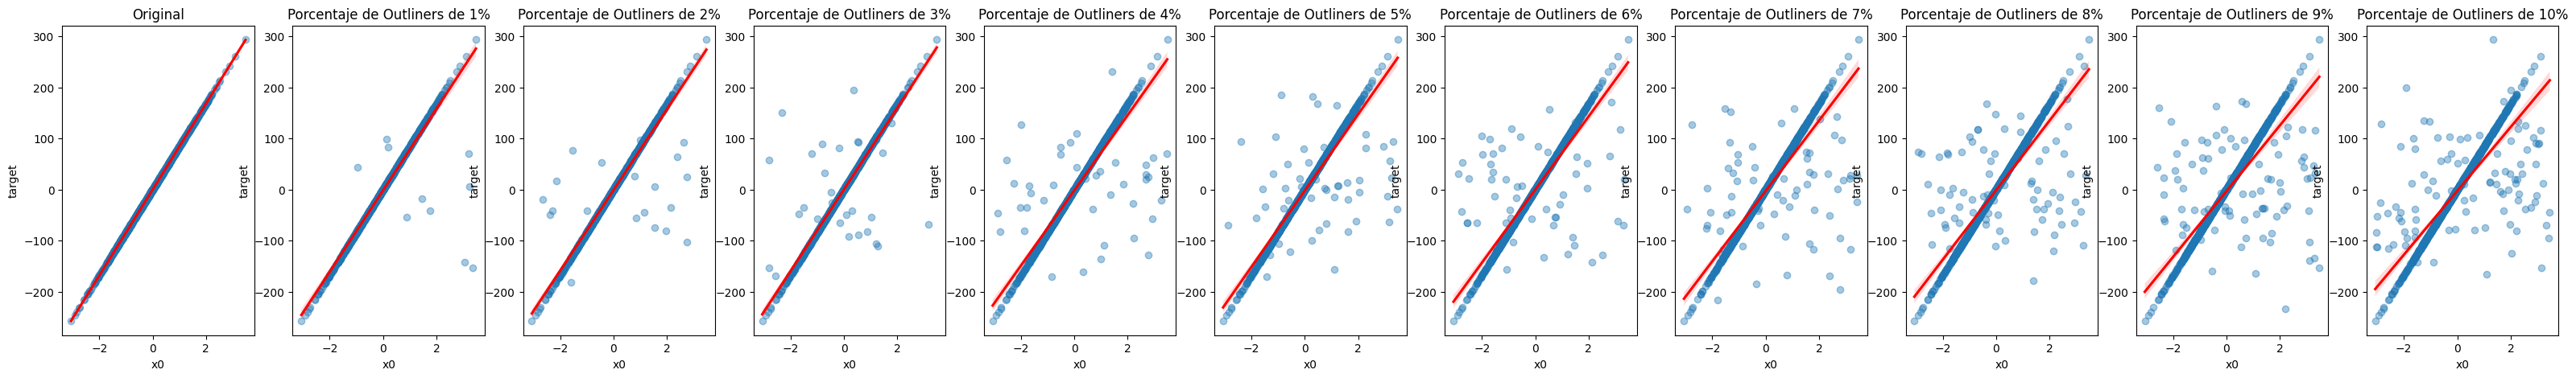

In [220]:
fig, axes = plt.subplots(1, 11, figsize=(40, 5))

sns.regplot(x='x0',
            y='target',
            data=data,
            ax=axes[0],
            scatter_kws={'alpha': 0.4},
            line_kws={'color': 'red'},
            ci=95)
axes[0].set_title('Original')

sns.regplot(x='x0',
            y='target',
            data=do1,
            ax=axes[1],
            scatter_kws={'alpha': 0.4},
            line_kws={'color': 'red'},
            ci=95)
axes[1].set_title('Porcentaje de Outliners de 1%')

sns.regplot(x='x0',
            y='target',
            data=do2,
            ax=axes[2],
            scatter_kws={'alpha': 0.4},
            line_kws={'color': 'red'},
            ci=95)
axes[2].set_title('Porcentaje de Outliners de 2%')

sns.regplot(x='x0',
            y='target',
            data=do3,
            ax=axes[3],
            scatter_kws={'alpha': 0.4},
            line_kws={'color': 'red'},
            ci=95)
axes[3].set_title('Porcentaje de Outliners de 3%')

sns.regplot(x='x0',
            y='target',
            data=do4,
            ax=axes[4],
            scatter_kws={'alpha': 0.4},
            line_kws={'color': 'red'},
            ci=95)
axes[4].set_title('Porcentaje de Outliners de 4%')

sns.regplot(x='x0',
            y='target',
            data=do5,
            ax=axes[5],
            scatter_kws={'alpha': 0.4},
            line_kws={'color': 'red'},
            ci=95)
axes[5].set_title('Porcentaje de Outliners de 5%')

sns.regplot(x='x0',
            y='target',
            data=do6,
            ax=axes[6],
            scatter_kws={'alpha': 0.4},
            line_kws={'color': 'red'},
            ci=95)
axes[6].set_title('Porcentaje de Outliners de 6%')

sns.regplot(x='x0',
            y='target',
            data=do7,
            ax=axes[7],
            scatter_kws={'alpha': 0.4},
            line_kws={'color': 'red'},
            ci=95)
axes[7].set_title('Porcentaje de Outliners de 7%')

sns.regplot(x='x0',
            y='target',
            data=do8,
            ax=axes[8],
            scatter_kws={'alpha': 0.4},
            line_kws={'color': 'red'},
            ci=95)
axes[8].set_title('Porcentaje de Outliners de 8%')

sns.regplot(x='x0',
            y='target',
            data=do9,
            ax=axes[9],
            scatter_kws={'alpha': 0.4},
            line_kws={'color': 'red'},
            ci=95)
axes[9].set_title('Porcentaje de Outliners de 9%')

sns.regplot(x='x0',
            y='target',
            data=do10,
            ax=axes[10],
            scatter_kws={'alpha': 0.4},
            line_kws={'color': 'red'},
            ci=95)
axes[10].set_title('Porcentaje de Outliners de 10%')

In [221]:
#Regresores
linear_regression = LinearRegression()
huber_regression = HuberRegressor() 
ridge_regression = RidgeCV()

def mse(target, prediction):
    n = target.size
    return np.sum((target - prediction)**2)/n

def regresor_outliers(data_outliner, model):
    X = data_outliner.drop('target', axis=1)
    y = data_outliner['target']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    model.fit(X_train, y_train)
    y_test_predict = model.predict(X_test)
    
    mse_test = mse(y_test, y_test_predict)
    
    return mse_test

mse_linear_test_1 = regresor_outliers(do1, linear_regression)
mse_linear_test_2 = regresor_outliers(do2, linear_regression)
mse_linear_test_3 = regresor_outliers(do3, linear_regression)
mse_linear_test_4 = regresor_outliers(do4, linear_regression)
mse_linear_test_5 = regresor_outliers(do5, linear_regression)
mse_linear_test_6 = regresor_outliers(do6, linear_regression)
mse_linear_test_7 = regresor_outliers(do7, linear_regression)
mse_linear_test_8 = regresor_outliers(do8, linear_regression)
mse_linear_test_9 = regresor_outliers(do9, linear_regression)
mse_linear_test_10 = regresor_outliers(do10, linear_regression)

mse_huber_test_1 = regresor_outliers(do1, huber_regression)
mse_huber_test_2 = regresor_outliers(do2, huber_regression)
mse_huber_test_3 = regresor_outliers(do3, huber_regression)
mse_huber_test_4 = regresor_outliers(do4, huber_regression)
mse_huber_test_5 = regresor_outliers(do5, huber_regression)
mse_huber_test_6 = regresor_outliers(do6, huber_regression)
mse_huber_test_7 = regresor_outliers(do7, huber_regression)
mse_huber_test_8 = regresor_outliers(do8, huber_regression)
mse_huber_test_9 = regresor_outliers(do9, huber_regression)
mse_huber_test_10 = regresor_outliers(do10, huber_regression)

mse_ridge_test_1 = regresor_outliers(do1, ridge_regression)
mse_ridge_test_2 = regresor_outliers(do2, ridge_regression)
mse_ridge_test_3 = regresor_outliers(do3, ridge_regression)
mse_ridge_test_4 = regresor_outliers(do4, ridge_regression)
mse_ridge_test_5 = regresor_outliers(do5, ridge_regression)
mse_ridge_test_6 = regresor_outliers(do6, ridge_regression)
mse_ridge_test_7 = regresor_outliers(do7, ridge_regression)
mse_ridge_test_8 = regresor_outliers(do8, ridge_regression)
mse_ridge_test_9 = regresor_outliers(do9, ridge_regression)
mse_ridge_test_10 = regresor_outliers(do10, ridge_regression)
#mse_huber = simulate_with_outliers(percentage_outliers, huber_regression)
#mse_ridge = simulate_with_outliers(percentage_outliers, ridge_regression)
mse_linear1= [mse_linear_test_1,mse_linear_test_2,mse_linear_test_3,mse_linear_test_4,mse_linear_test_5,
                mse_linear_test_6,mse_linear_test_7,mse_linear_test_8,mse_linear_test_9,mse_linear_test_10]
mse_huber1 = [mse_huber_test_1,mse_huber_test_2,mse_huber_test_3,mse_huber_test_4,mse_huber_test_5,
                 mse_huber_test_6,mse_huber_test_7,mse_huber_test_8,mse_huber_test_9,mse_huber_test_10]
mse_ridge1 = [mse_ridge_test_1,mse_ridge_test_2,mse_ridge_test_3,mse_ridge_test_4,mse_ridge_test_5,
                mse_ridge_test_6,mse_ridge_test_7,mse_ridge_test_8,mse_ridge_test_9,mse_ridge_test_10]

In [222]:
pd.DataFrame(list(zip(mse_linear1,mse_huber1,mse_ridge1)), columns=['Linear regresor','Huber regresor','Ridge regresor'])

,Linear regresor,Huber regresor,Ridge regresor
0,1148.574316,1208.626200,1147.313951
1,649.157106,689.371190,649.135785
2,92.177204,90.335589,92.663435
3,750.930660,807.312739,751.430843
4,1077.397781,1256.579140,1076.607169
5,1315.360993,1458.022783,1315.530521
6,1448.658281,1692.440539,1448.858850
7,1676.452074,1932.176448,1676.634133
8,3759.595665,4857.988065,3756.667794
9,2656.110483,3601.225035,2654.948830


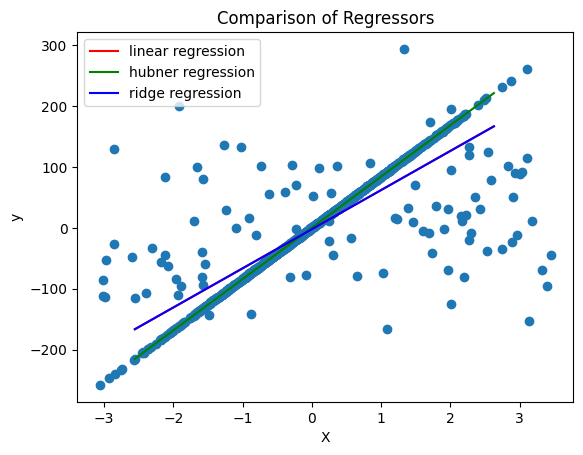

In [224]:
x = np.linspace(X_test.min(), X_test.max(), 7)
coef_linear = linear_regression.coef_
coef_ = linear_regression.coef_ * x + linear_regression.intercept_
plt.plot(x, coef_, "r-", label="linear regression")
coef_ridge = huber_regression.coef_
coef_ = huber_regression.coef_ * x + huber_regression.intercept_
plt.plot(x, coef_, "g-", label="hubner regression")
coef_ridge = ridge_regression.coef_
coef_ = ridge_regression.coef_ * x + ridge_regression.intercept_
plt.plot(x, coef_, "b-", label="ridge regression")
plt.scatter(do10.drop('target', axis=1),do10['target'])
plt.title("Comparison of Regressors")
plt.xlabel("X")
plt.ylabel("y")
plt.legend(loc=0)
plt.show()

Se observa que Hubner es más robusta al ruido en comparación con Linear y Ridge que se ven afectadas por los outliners.

In [204]:
linear_regression = LinearRegression()
huber_regression = HuberRegressor()
ridge_regression = RidgeCV()

def mse(target, prediction):
    n = target.size
    return np.sum((target - prediction)**2)/n


X = do2.drop('target', axis=1)
y = do2['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = HuberRegressor(alpha=0.0, epsilon=1.0)
model.fit(X_train, y_train)
y_test_predict = model.predict(X_test)

mse_test = mse(y_test, y_test_predict)

print(mse_test)

326.3304840518622


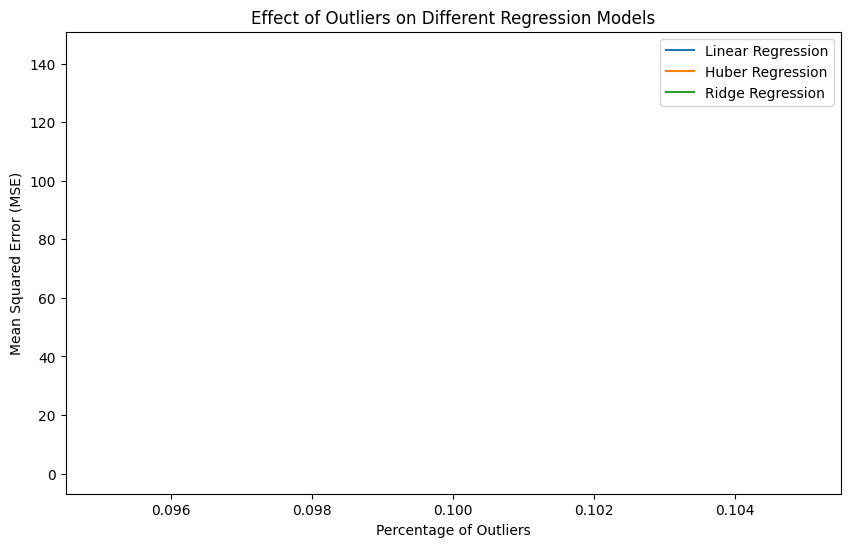

In [102]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, HuberRegressor, Ridge
from sklearn.metrics import mean_squared_error
from sklearn.datasets import make_regression

def generate_outliers(X, y, percentage, extreme_outliers=True):
    np.random.seed(42)
    
    if extreme_outliers:
        outlier_factor = 3
    else:
        outlier_factor = 1.5

    n_outliers = int(percentage * len(y))
    indices = np.random.choice(len(y), n_outliers, replace=False)

    if len(X.shape) == 1:
        X[indices] += outlier_factor * np.std(X) * np.random.randn(n_outliers)
    else:
        X[indices, :] += outlier_factor * np.std(X, axis=0) * np.random.randn(n_outliers, X.shape[1])

    y[indices] += outlier_factor * np.std(y) * np.random.randn(n_outliers)

    return X, y

def fit_and_evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    return mse

def simulate_with_outliers(percentage_outliers, model, extreme_outliers=False):
    mse_list = []

    for percentage in percentage_outliers:
        X, y = make_regression(n_samples=100, n_features=1, noise=0.5, random_state=42)

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        X_train, y_train = generate_outliers(X_train, y_train, percentage, extreme_outliers)

        mse = fit_and_evaluate_model(model, X_train, y_train, X_test, y_test)
        mse_list.append(mse)

    return mse_list

# Simulación con diferentes porcentajes de outliers
percentage_outliers = np.arange(0.1, 0.11, 0.01)

# Modelos a probar
linear_regression = LinearRegression()
huber_regression = HuberRegressor()
ridge_regression = Ridge()

# Simulación y evaluación para cada modelo
mse_linear = simulate_with_outliers(percentage_outliers, linear_regression)
mse_huber = simulate_with_outliers(percentage_outliers, huber_regression)
mse_ridge = simulate_with_outliers(percentage_outliers, ridge_regression)

# Graficar resultados
plt.figure(figsize=(10, 6))
plt.plot(percentage_outliers, mse_linear, label='Linear Regression')
plt.plot(percentage_outliers, mse_huber, label='Huber Regression')
plt.plot(percentage_outliers, mse_ridge, label='Ridge Regression')

plt.xlabel('Percentage of Outliers')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Effect of Outliers on Different Regression Models')
plt.legend()
plt.show()


In [103]:
pd.DataFrame(list(zip(mse_linear,mse_huber,mse_ridge)), columns=['Linear regresor','Huber regresor','Ridge regresor'])

,Linear regresor,Huber regresor,Ridge regresor
0,136.344178,0.314471,143.727119


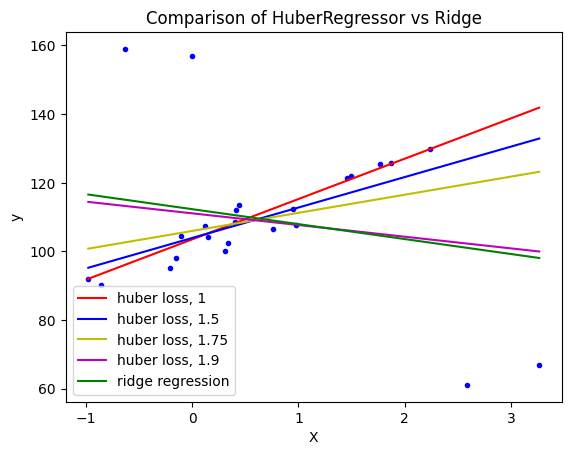

In [47]:

import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import make_regression
from sklearn.linear_model import HuberRegressor, Ridge

# Generate toy data.
rng = np.random.RandomState(0)
X, y = make_regression(
    n_samples=20, n_features=1, random_state=0, noise=4.0, bias=100.0
)

# Add four strong outliers to the dataset.
X_outliers = rng.normal(0, 0.5, size=(4, 1))
y_outliers = rng.normal(0, 2.0, size=4)
X_outliers[:2, :] += X.max() + X.mean() / 4.0
X_outliers[2:, :] += X.min() - X.mean() / 4.0
y_outliers[:2] += y.min() - y.mean() / 4.0
y_outliers[2:] += y.max() + y.mean() / 4.0
X = np.vstack((X, X_outliers))
y = np.concatenate((y, y_outliers))
plt.plot(X, y, "b.")

# Fit the huber regressor over a series of epsilon values.
colors = ["r-", "b-", "y-", "m-"]

x = np.linspace(X.min(), X.max(), 7)
epsilon_values = [1, 1.5, 1.75, 1.9]
for k, epsilon in enumerate(epsilon_values):
    huber = HuberRegressor(alpha=0.0, epsilon=epsilon)
    huber.fit(X, y)
    coef_ = huber.coef_ * x + huber.intercept_
    plt.plot(x, coef_, colors[k], label="huber loss, %s" % epsilon)

# Fit a ridge regressor to compare it to huber regressor.
ridge = Ridge(alpha=0.0, random_state=0)
ridge.fit(X, y)
coef_ridge = ridge.coef_
coef_ = ridge.coef_ * x + ridge.intercept_
plt.plot(x, coef_, "g-", label="ridge regression")

plt.title("Comparison of HuberRegressor vs Ridge")
plt.xlabel("X")
plt.ylabel("y")
plt.legend(loc=0)
plt.show()

In [ ]:
#Regresores do
from sklearn.metrics import mean_squared_error

def mse(target, prediction):
    n = target.size
    return np.sum((target - prediction)**2)/n

def regresor_outliers(data_outliner):
    X = data_outliner.drop('target', axis=1)
    y = data_outliner['target']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    linear_regression = LinearRegression()
    huber_regression = HuberRegressor() #alpha=0.0, epsilon=2.0
    ridge_regression = RidgeCV()

    linear_regression.fit(X_train, y_train)
    huber_regression.fit(X_train, y_train)
    ridge_regression.fit(X_train, y_train)

    y_linear_predict = linear_regression.predict(X_test)
    y_huber_predict = huber_regression.predict(X_test)
    y_ridge_predict = ridge_regression.predict(X_test)

    mse_test_linear = mse(y_test, y_linear_predict)
    mse_test_huber = mse(y_test, y_huber_predict)
    mse_test_ridge = mse(y_test, y_ridge_predict)
    
    return mse_test_linear, mse_test_huber, mse_test_ridge #, linear_regression, huber_regression, ridge_regression, X_test, y_test

mse_linear_test_1, mse_huber_test_1, mse_ridge_test_1 = regresor_outliers(do1)
mse_linear_test_2, mse_huber_test_2, mse_ridge_test_2 = regresor_outliers(do2)
mse_linear_test_3, mse_huber_test_3, mse_ridge_test_3 = regresor_outliers(do3)
mse_linear_test_4, mse_huber_test_4, mse_ridge_test_4 = regresor_outliers(do4)
mse_linear_test_5, mse_huber_test_5, mse_ridge_test_5 = regresor_outliers(do5)
mse_linear_test_6, mse_huber_test_6, mse_ridge_test_6 = regresor_outliers(do6)
mse_linear_test_7, mse_huber_test_7, mse_ridge_test_7 = regresor_outliers(do7)
mse_linear_test_8, mse_huber_test_8, mse_ridge_test_8 = regresor_outliers(do8)
mse_linear_test_9, mse_huber_test_9, mse_ridge_test_9= regresor_outliers(do9)
mse_linear_test_10, mse_huber_test_10, mse_ridge_test_10 = regresor_outliers(do10)

'''
mse_huber_test_1 = regresor_outliers(do1, huber_regression)
 = regresor_outliers(do2, huber_regression)
 = regresor_outliers(do3, huber_regression)
 = regresor_outliers(do4, huber_regression)
 = regresor_outliers(do5, huber_regression)
 = regresor_outliers(do6, huber_regression)
 = regresor_outliers(do7, huber_regression)
 = regresor_outliers(do8, huber_regression)
 = regresor_outliers(do9, huber_regression)
 = regresor_outliers(do10, huber_regression)

 = regresor_outliers(do1, ridge_regression)
 = regresor_outliers(do2, ridge_regression)
 = regresor_outliers(do3, ridge_regression)
 = regresor_outliers(do4, ridge_regression)
 = regresor_outliers(do5, ridge_regression)
 = regresor_outliers(do6, ridge_regression)
 = regresor_outliers(do7, ridge_regression)
 = regresor_outliers(do8, ridge_regression)
 = regresor_outliers(do9, ridge_regression)
 = regresor_outliers(do10, ridge_regression)
 '''
#mse_huber = simulate_with_outliers(percentage_outliers, huber_regression)
#mse_ridge = simulate_with_outliers(percentage_outliers, ridge_regression)
mse_linear2= [mse_linear_test_1,mse_linear_test_2,mse_linear_test_3,mse_linear_test_4,mse_linear_test_5,
                mse_linear_test_6,mse_linear_test_7,mse_linear_test_8,mse_linear_test_9,mse_linear_test_10]
mse_huber2 = [mse_huber_test_1,mse_huber_test_2,mse_huber_test_3,mse_huber_test_4,mse_huber_test_5,
                 mse_huber_test_6,mse_huber_test_7,mse_huber_test_8,mse_huber_test_9,mse_huber_test_10]
mse_ridge2 = [mse_ridge_test_1,mse_ridge_test_2,mse_ridge_test_3,mse_ridge_test_4,mse_ridge_test_5,
                mse_ridge_test_6,mse_ridge_test_7,mse_ridge_test_8,mse_ridge_test_9,mse_ridge_test_10]

In [ ]:
# Graficar resultados
plt.figure(figsize=(10, 6))
plt.plot([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], mse_linear, label='Linear Regression')
plt.plot([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], mse_huber, label='Huber Regression')
plt.plot([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], mse_ridge, label='Ridge Regression')
plt.xlabel('Percentage of Outliers')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Effect of Outliers on Different Regression Models')
plt.legend()
plt.show()

## Problema de Clasificación

### Ejercicio 6

En este ejercicio vamos a jugar un poco con descenso de gradiente. Para esto consideremos lo visto en clase que es el problema de regresión.

Como paso inicial, vamos a sacarnos de encima la parte teórica. Recordemos que partimos del siguiente modelo

$$
y = \beta_0 + \beta_1 \cdot x
$$

En este caso nuestra función objetivo a optimizar será:

$$
MSE = ||y-\hat{y}||^2
$$


Para calcular el gradiente de la función de error cuadrático medio (MSE) con respecto a los parámetros $\beta_0$ y $\beta_1$, es útil primero expresar la función de coste de forma más explicita. Dado que $\hat{y} = \beta_0 + \beta_1 \cdot x$, podemos reescribir la función MSE como sigue:

$$
MSE(\beta_0, \beta_1) = \frac{1}{N} \sum_{i=1}^{N} (y_i - \beta_0 - \beta_1 \cdot x_i)^2
$$

Aquí, $N$ es el número de observaciones en el conjunto de datos y $y_i$ y $x_i$ son el valor observado y el valor de la característica correspondiente para la i-ésima observación.

El gradiente de la función de coste está compuesto por las derivadas parciales de la función de coste con respecto a cada uno de los parámetros. Así, el gradiente es un vector de la forma:

$$
\nabla MSE(\beta_0, \beta_1) = \left[ \frac{\partial MSE}{\partial \beta_0}, \frac{\partial MSE}{\partial \beta_1} \right]
$$

Las derivadas parciales se pueden calcular como sigue:

$$
\frac{\partial MSE}{\partial \beta_0} = \frac{-2}{N} \sum_{i=1}^{N} (y_i - \beta_0 - \beta_1 \cdot x_i)
$$

$$
\frac{\partial MSE}{\partial \beta_1} = \frac{-2}{N} \sum_{i=1}^{N} x_i \cdot (y_i - \beta_0 - \beta_1 \cdot x_i)
$$

Así que finalmente tenemos:

$$
\nabla MSE(\beta_0, \beta_1) = \left[ \frac{-2}{N} \sum_{i=1}^{N} (y_i - \beta_0 - \beta_1 \cdot x_i), \frac{-2}{N} \sum_{i=1}^{N} x_i \cdot (y_i - \beta_0 - \beta_1 \cdot x_i) \right]
$$

El cálculo del gradiente se usa en el descenso de gradiente para actualizar los parámetros $\beta_0$ y $\beta_1$ en cada iteración, en dirección opuesta al gradiente, para minimizar la función de coste.

Estos cálculos se pueden implementar en código Python de la siguiente manera:

```python
def gradient(X, y, beta0, beta1):
    N = len(y)
    y_hat = beta0 + beta1 * X

    d_beta0 = (-2/N) * np.sum(y - y_hat)
    d_beta1 = (-2/N) * np.sum(X * (y - y_hat))

    return d_beta0, d_beta1
```

Ahora, si quisieramos realizar esto de manera matricial, podemos hacer lo siguiente:

Primero, necesitamos cambiar la representación de nuestros datos. Podemos agregar un vector de unos a nuestra matriz de características para representar el término de intersección $\beta_0$. De esta manera, $X$ toma esta forma:

$$
X = \begin{bmatrix}
1 & x_1 \\
1 & x_2 \\
\vdots & \vdots \\
1 & x_N \\
\end{bmatrix}
$$

Y nuestro vector de parámetros $\theta$ se verá así:

$$
\theta = \begin{bmatrix}
\beta_0 \\
\beta_1 \\
\end{bmatrix}
$$

Entonces, nuestra predicción $\hat{y}$ se calcula como $X\theta$:

$$
\hat{y} = X\theta = \begin{bmatrix}
1 & x_1 \\
1 & x_2 \\
\vdots & \vdots \\
1 & x_N \\
\end{bmatrix} \cdot \begin{bmatrix}
\beta_0 \\
\beta_1 \\
\end{bmatrix}
$$

Nuestra función de coste MSE se ve de la siguiente manera en forma matricial:

$$
MSE(\theta) = \frac{1}{N} (y - X\theta)^T (y - X\theta)
$$

Las derivadas parciales de esta función de coste con respecto a los parámetros se pueden calcular de la siguiente manera:

$$
\frac{\partial MSE}{\partial \theta} = \frac{-2}{N} X^T (y - X\theta)
$$


Esto se puede implementar en Python de la siguiente manera:

In [225]:
def gradient(X: np.ndarray, y: np.ndarray, theta: np.ndarray) -> np.ndarray:
    """
    Esta función calcula el gradiente de la función de coste del error cuadrático medio (MSE)
    para una regresión lineal simple. La función toma como entrada la matriz de características X,
    el vector de observaciones y y el vector de parámetros theta, y devuelve el gradiente, que
    es un vector de las mismas dimensiones que theta.

    Params:
    X : numpy.ndarray
        La matriz de características extendida que incluye un vector de unos. De tamaño (N, d),
        donde N es el número de observaciones y d es el número de características (incluyendo el
        término de intersección).

    y : numpy.ndarray
        El vector de observaciones. De tamaño (N,), donde N es el número de observaciones.

    theta : numpy.ndarray
        El vector de parámetros. De tamaño (d,), donde d es el número de características
        (incluyendo el término de intersección).

    Returns:
    grad : numpy.ndarray
        El gradiente de la función de coste. Un vector de las mismas dimensiones que theta.

    Examples:
    >>> X = np.array([[1, 1], [1, 2], [1, 3]])
    >>> y = np.array([2, 3, 4])
    >>> theta = np.array([0, 0])
    >>> gradient(X, y, theta)
    array([-4., -8.])
    """
    N = len(y)
    y_hat = X.dot(theta)
    
    grad = (-2 / N) * X.T.dot(y - y_hat)

    return grad


Aquí, `X` es la matriz de características extendida que incluye un vector de unos, `y` es el vector de observaciones, y `theta` es el vector de parámetros. La función devuelve el gradiente, que es un vector de las mismas dimensiones que `theta`.

#### Gradiente Descendente

Ahora que sabemos calcular el gradiente, vamos a:

1. Crear una función _GD_ que compute el gradiente descendente. Debe tener condición de frenado
por nr de épocas pero también por tolerancia.
2. Generamos un dataset (con _generate_dataset_ de los ejercicios anteriores, utilizando un bias conocido y solo 1 feature)
3. Inicializamos un vector $(\beta_0, \beta_1)$ al azar.
4. Tratamos de calcular los mejores parámetros con el algoritmo.
5. Guardamos la función de perdida en train y test en cada época.

In [231]:
from sklearn.linear_model import LinearRegression, HuberRegressor, RidgeCV
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split

data = generate_dataset(n_samples=1000,
                        n_features=1, 
                        n_informative=1,
                        n_targets=1,
                        noise=0.5,
                        output='dataframe')

theta = np.array([1, 2])
X = data.drop('target', axis=1)
y = data['target']

flag = True
epochs = 0
while flag:
    thetaNew = gradient(X, y, theta)

    if epochs>=10000:
        flag = False
    if abs(thetaNew-theta) < 0.1:
        flag = False
    epochs += 1

    theta = thetaNew
    

ValueError: Dot product shape mismatch, (1000, 1) vs (2,)

#### Gradiente Descendente Estocástico

Ahora que sabemos calcular el gradiente, vamos a:

1. Crear una función _SGD_ que compute el gradiente descendente estocástico.
2. Generamos un dataset (con _generate_dataset_ de los ejercicios anteriores, utilizando un bias conocido y solo 1 feature)
3. Inicializamos un vector $(\beta_0, \beta_1)$ al azar.
4. Tratamos de calcular los mejores parámetros con el algoritmo.
5. Guardamos la función de perdida en train y test en cada época.

Analice:

1. Cómo se comportan estos algoritmos? se puede ver la diferencia entre SGD y GD?.
2. Cómo afecto el _learning rate_ a estos algoritmos? Realice una simulación del mismo cambiando el `lr`.
3. Compare en una curva de Perdida vs Epoch los dos algoritmos. Nota algo interesante?

### Ejercicio 7

En este ejercicio vamos a considerar la regresión logística como un problema de clasificación binaria.
La implementación de la misma podemos considerar la siguiente:

```python

class LogisticRegressionSGD():
    def __init__(self, lr=0.01, max_iter=1000, tol=1e-3, random_state=42):
        self.lr = lr
        self.max_iter = max_iter
        self.tol = tol
        self.random_state = random_state
        self.weights = None
        self.loss = None
        self.loss_history = None
        self.grad_history = None
        self.theta_history = None

    def fit(self, X, y):
        """
        Fit the model according to the given training data.

        Params:
        X : numpy.ndarray
            The training input samples. A 2D array of shape (n_samples, n_features).

        y : numpy.ndarray
            The target values. An array of shape (n_samples,).

        Returns:
        self : LogisticRegressionSGD
            The fitted model.
        """
        np.random.seed(self.random_state)
        self.weights = np.random.normal(size=X.shape[1])
        self.loss_history = []
        self.grad_history = []
        self.theta_history = []

        self.SGD(X, y)

        return self

    def _step(self, X, y):
        """
        Perform a single gradient step.

        Params:
        X : numpy.ndarray
            The training input samples. A 2D array of shape (n_samples, n_features).

        y : numpy.ndarray
            The target values. An array of shape (n_samples,).

        Returns:
        loss : float
            The value of the loss function for the current value of the weights.

        grad : numpy.ndarray
            The gradient of the loss function for the current value of the weights.
        """
        N = len(y)
        y_hat = self.logit(X)
        loss = -np.mean(y * np.log(y_hat) + (1 - y) * np.log(1 - y_hat))
        grad = (-1 / N) * X.T.dot(y - y_hat)

        return loss, grad

    def SGD(self, X, y):
        """
        Perform the stochastic gradient descent optimization algorithm.

        Params:
        X : numpy.ndarray
            The training input samples. A 2D array of shape (n_samples, n_features).

        y : numpy.ndarray
            The target values. An array of shape (n_samples,).
        """
        ...

    def logit(self, X):
        """
        Calculate the logit of a set of observations.

        Params:
        X : numpy.ndarray
            The training input samples. A 2D array of shape (n_samples, n_features).

        Returns:
        logit : numpy.ndarray
            The logit of the observations. An array of shape (n_samples,).
        """
        return 1 / (1 + np.exp(-X.dot(self.weights)))
    
    def predict_proba(self, X):
        """
        Predict the probability of each class for a set of observations.

        Params:
        X : numpy.ndarray
            The training input samples. A 2D array of shape (n_samples, n_features).

        Returns:
        proba : numpy.ndarray
            The predicted probability of each class. An array of shape (n_samples,).
        """
        return self.logit(X)
    
    def predict(self, X):
        """
        Predict the class of a set of observations.

        Params:
        X : numpy.ndarray
            The training input samples. A 2D array of shape (n_samples, n_features).

        Returns:
        y_pred : numpy.ndarray
            The predicted class. An array of shape (n_samples,).
        """
        return (self.predict_proba(X) >= 0.5).astype(int)
    
    def score(self, X, y):
        """
        Calculate the accuracy of the model.

        Params:
        X : numpy.ndarray
            The training input samples. A 2D array of shape (n_samples, n_features).

        y : numpy.ndarray
            The target values. An array of shape (n_samples,).

        Returns:
        score : float
            The accuracy of the model.
        """
        return np.mean(self.predict(X) == y)

```

Con esta clase, vamos a tomar el dataset de breast cancer y vamos a realizar una clasificación binaria.
La idea de este ejercicio es que puedan jugar con la manera de obtener los hiperparámetros óptimos para el modelo.

Para ello van a tener que completar el método `SGD` de la clase `LogisticRegressionSGD` y luego realizar una búsqueda de grilla para encontrar los mejores hiperparámetros.

In [ ]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

X,y = load_breast_cancer(return_X_y=True)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)